In [70]:
from turtle import distance
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import directed_hausdorff
%matplotlib inline


# Check Values

In [71]:
scale_x = 4.06
scale_y = -4.06
translate_x = 963
translate_y = 373

def T(world_point):
    return world_point*np.array([scale_x, scale_y]) + np.array([translate_x, translate_y]) 

In [72]:
def image_to_array(path): 
    
    print(path)
    image =  cv.imread(path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return gray_image

In [162]:
cd = pd.read_csv("../data/overall__imu__data.csv")

positions = np.stack([cd['positions_x_ground_truth'], cd['positions_y_ground_truth']], axis=1)
orientations = cd['orientation_measurement']
steerings = cd['steering_input']
image_positions = []
for p in positions: 
    image_positions.append(T(p))
image_positions = np.array(image_positions)

In [158]:
map = image_to_array("../data/map/carla_map_unscaled.png")

../data/map/carla_map_unscaled.png


In [159]:
plt.imshow(map)    
plt.scatter(image_positions[:,0], image_positions[:,1])
plt.scatter(image_positions[0,0], image_positions[0,1])


In [160]:
steerings.min()

-6.530099750895616e+16

In [163]:
%matplotlib qt
plt.plot(cd['timestamps'], (steerings))
plt.plot(cd['timestamps'], np.rad2deg(orientations))
plt.grid()

In [164]:
plt.plot(cd['timestamps'], cd['velocities_ground_truth'].values, label="velocity")
plt.plot(cd['timestamps'], cd['acceleration_input'], label="acc input")
plt.plot(cd['timestamps'], cd['acceleration_measurement'], label = "acc measure")
plt.legend()
plt.grid()

## Umberechnung der Winkelrichtung

In [87]:
angles = np.arange(0, 2*np.pi, .10)

In [102]:
angles
mirrored_angles = 2*np.pi - angles
rotated_angles = (mirrored_angles + (np.pi/2)) % (2*np.pi)

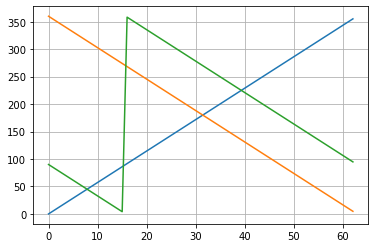

In [103]:
plt.plot(np.rad2deg(angles))
plt.plot(np.rad2deg(mirrored_angles))
plt.plot(np.rad2deg(rotated_angles))
plt.grid()

In [93]:
converted_angles

array([6.28318531, 6.18318531, 6.08318531, 5.98318531, 5.88318531,
       5.78318531, 5.68318531, 5.58318531, 5.48318531, 5.38318531,
       5.28318531, 5.18318531, 5.08318531, 4.98318531, 4.88318531,
       4.78318531, 4.68318531, 4.58318531, 4.48318531, 4.38318531,
       4.28318531, 4.18318531, 4.08318531, 3.98318531, 3.88318531,
       3.78318531, 3.68318531, 3.58318531, 3.48318531, 3.38318531,
       3.28318531, 3.18318531, 3.08318531, 2.98318531, 2.88318531,
       2.78318531, 2.68318531, 2.58318531, 2.48318531, 2.38318531,
       2.28318531, 2.18318531, 2.08318531, 1.98318531, 1.88318531,
       1.78318531, 1.68318531, 1.58318531, 1.48318531, 1.38318531,
       1.28318531, 1.18318531, 1.08318531, 0.98318531, 0.88318531,
       0.78318531, 0.68318531, 0.58318531, 0.48318531, 0.38318531,
       0.28318531, 0.18318531, 0.08318531])

## Speichern der Distanzen 
Die Distanzen werden gespeichert und gemittelt (Median oder Mean). Anschließen wird dasselbe für die Messung getan. Aus dem Partikelresulatet wird eine Normalbverteilung erstellt, die MEssung wird in die PDF gegeben --> Gewicht